In [1]:
%pip install nbformat>=4.2.0

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import re

In [3]:
url = "https://www.badmintonstatistics.net/home/RankingsPartial?date=2025-01-06&category=MS&country=%&page=1&pagesize=100"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}
response = requests.get(url, headers=headers)
print(response.text[:500])



<div id="overlay"><img id="overlaywait" src="/img/wait-large.gif" /></div>
<input type="hidden" data-val="true" data-val-required="The totalRows field is required." id="rankinglist_totalRows" name="rankinglist.totalRows" value="1971" />
<div class="reportcontainer"><table class="reportTable">
 <thead>
 <tr>
<th>Players</th>
<th>Rk</th>
<th>Category</th>
<th>Points</th>
</tr>
</thead>
<tbody>
<tr>
<td><img src="img/flags/China.png" height="10px" title="China"> <a href="Player?playerid=1320222


In [4]:
tables = pd.read_html(response.text)
df = tables[0]

print(df.head())

              Players  Rk Category  Points
0            SHI Yuqi   1       MS  101015
1     Anders ANTONSEN   2       MS   94821
2      Viktor AXELSEN   3       MS   85210
3    Jonatan CHRISTIE   4       MS   84847
4  Kunlavut VITIDSARN   5       MS   78808


In [5]:
def get_first_mondays(start_year, end_year):
    dates = []
    for year in range(start_year, end_year + 1):
        mondays = pd.date_range(f'{year}-01-01', f'{year}-12-31', freq='WOM-1MON')
        dates.extend(mondays)
    return [d.strftime('%Y-%m-%d') for d in dates]

In [6]:
def fetch_and_parse_ranking(date_str, category='MS', page_size=100):
    url = f"https://www.badmintonstatistics.net/home/RankingsPartial?date={date_str}&category={category}&country=%&page=1&pagesize=100&type=unified"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', class_='reportTable')
    if not table:
        return []
    rows = table.find_all('tr')[1:]
    data = []
    for row in rows:
        cols = row.find_all('td')
        if not cols or len(cols) < 4:
            continue
        player_cell = cols[0]
        img = player_cell.find('img')
        country = img['title'] if img and 'title' in img.attrs else None
        link = player_cell.find('a', href=True)
        player_id = None
        player_name = player_cell.get_text(strip=True)
        if link:
            href = link['href']
            match = re.search(r'playerid=(\d+)', href)
            if match:
                player_id = match.group(1)
            player_name = link.get_text(strip=True)
        rank = cols[1].get_text(strip=True)
        category_val = cols[2].get_text(strip=True)
        points = cols[3].get_text(strip=True)
        data.append({
            'Player': player_name,
            'Country': country,
            'Rank': int(rank),
            'Category': category_val,
            'Points': points,
            'Date': date_str,
            'PlayerID': player_id
        })
    return data



In [7]:
def get_player_win_loss_data(player_id, start_date='2001-01-01', end_date='2025-07-01'):
    url = (
        f"https://www.badmintonstatistics.net/home/playerdetails"
        f"?playerid={player_id}"
        f"&year=-1"
        f"&level=all"
        f"&category=%25"
        f"&round=%25"
        f"&country=%25"
        f"&partner=%25"
        f"&rank=%25"
        f"&hand=%25"
        f"&height=%25"
        f"&qualification=%25"
        f"&startdate={start_date}"
        f"&enddate={end_date}"
    )
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    win_loss_pattern = r'Win/Loss:\s*(\d+)-(\d+)(?:\s*\(Walkovers:\s*(\d+)-(\d+)\))?'
    text = soup.get_text()
    match = re.search(win_loss_pattern, text)
    overall_stats = {}
    if match:
        overall_stats = {
            'wins': int(match.group(1)),
            'losses': int(match.group(2)),
            'walkover_wins': int(match.group(3)) if match.group(3) else 0,
            'walkover_losses': int(match.group(4)) if match.group(4) else 0
        }
    return overall_stats

In [8]:
if __name__ == '__main__':
    # Step 1: Find top 10 Indian players by best-ever rank
    start_year = 2001
    end_year = 2025
    categories = ['MS', 'WS']  # Add or remove as needed
    all_data = []
    first_mondays = get_first_mondays(start_year, end_year)

    for category in categories:
        for date_str in first_mondays:
            print(f"Fetching {category} rankings for {date_str}...")
            week_data = fetch_and_parse_ranking(date_str, category)
            all_data.extend(week_data)
            time.sleep(1)

    df_full = pd.DataFrame(all_data)
    indian_players = df_full[(df_full['Country'] == 'India') & (df_full['PlayerID'].notnull())].copy()
    indian_players['Rank'] = indian_players['Rank'].astype(int)
    indian_players['Year'] = pd.to_datetime(indian_players['Date']).dt.year

    best_ranks = (indian_players
        .sort_values('Rank')
        .drop_duplicates(subset=['Player', 'Category', 'PlayerID'], keep='first')
        .sort_values('Rank')
        .head(10)
    )
    print("\nTop 10 Indian players by highest world rank:")
    print(best_ranks[['Player', 'Category', 'Rank', 'Year', 'PlayerID']])

    # Step 2: Fetch win-loss records for those top 10 players
    win_loss_records = []
    for _, row in best_ranks.iterrows():
        player_id = row['PlayerID']
        player_name = row['Player']
        category = row['Category']
        print(f"Extracting win-loss for {player_name} ({category})...")
        stats = get_player_win_loss_data(player_id, start_date='2001-01-01', end_date='2025-12-31')
        if stats and 'wins' in stats and 'losses' in stats:
            wins = stats['wins']
            losses = stats['losses']
            win_rate = wins / (wins + losses) if (wins + losses) > 0 else 0
            win_loss_records.append({
                'Player': player_name,
                'Category': category,
                'Wins': wins,
                'Losses': losses,
                'Win_Rate': win_rate,
                'Best_Rank': row['Rank'],
                'Best_Rank_Year': row['Year'],
                'PlayerID': player_id
            })
        time.sleep(2)

    win_loss_df = pd.DataFrame(win_loss_records)
    win_loss_df.to_csv('top10_indian_players_win_loss_2001_2025.csv', index=False)
    print("\nWin-Loss Data for Top 10 Indian Players:")
    print(win_loss_df)

Fetching MS rankings for 2001-01-01...
Fetching MS rankings for 2001-02-05...
Fetching MS rankings for 2001-03-05...
Fetching MS rankings for 2001-04-02...
Fetching MS rankings for 2001-05-07...
Fetching MS rankings for 2001-06-04...
Fetching MS rankings for 2001-07-02...
Fetching MS rankings for 2001-08-06...
Fetching MS rankings for 2001-09-03...
Fetching MS rankings for 2001-10-01...
Fetching MS rankings for 2001-11-05...
Fetching MS rankings for 2001-12-03...
Fetching MS rankings for 2002-01-07...
Fetching MS rankings for 2002-02-04...
Fetching MS rankings for 2002-03-04...
Fetching MS rankings for 2002-04-01...
Fetching MS rankings for 2002-05-06...
Fetching MS rankings for 2002-06-03...
Fetching MS rankings for 2002-07-01...
Fetching MS rankings for 2002-08-05...
Fetching MS rankings for 2002-09-02...
Fetching MS rankings for 2002-10-07...
Fetching MS rankings for 2002-11-04...
Fetching MS rankings for 2002-12-02...
Fetching MS rankings for 2003-01-06...
Fetching MS rankings for 

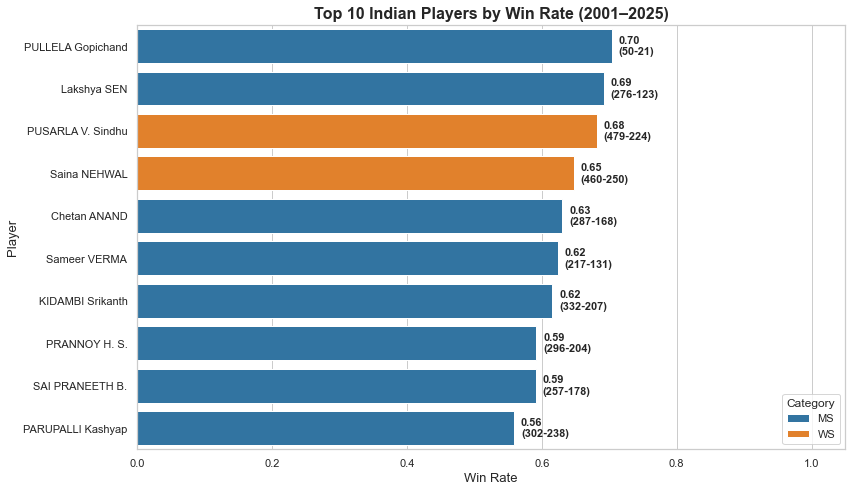

In [9]:
plot_df = win_loss_df.sort_values('Win_Rate', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")
palette = {'MS': '#1f77b4', 'WS': '#ff7f0e'}

ax = sns.barplot(
    data=plot_df,
    x='Win_Rate',
    y='Player',
    hue='Category',
    dodge=False,
    palette=palette
)

# Add value labels
for i, (win_rate, wins, losses) in enumerate(zip(plot_df['Win_Rate'], plot_df['Wins'], plot_df['Losses'])):
    ax.text(
        win_rate + 0.01, i, f"{win_rate:.2f}\n({wins}-{losses})",
        va='center', ha='left', fontsize=11, fontweight='bold'
    )

plt.title('Top 10 Indian Players by Win Rate (2001–2025)', fontsize=16, weight='bold')
plt.xlabel('Win Rate', fontsize=13)
plt.ylabel('Player', fontsize=13)
plt.xlim(0, 1.05)
plt.legend(title="Category", loc='lower right')
plt.tight_layout()
plt.show()

    Year Category  Player
0   2001       MS       6
1   2001       WS       2
2   2002       MS       4
3   2002       WS       2
4   2003       MS       5
5   2003       WS       3
6   2004       MS       4
7   2004       WS       3
8   2005       MS       8
9   2005       WS       4
10  2006       MS       8
11  2006       WS       5
12  2007       MS       7
13  2007       WS       3
14  2008       MS       5
15  2008       WS       4
16  2009       MS       7
17  2009       WS       5
18  2010       MS       7
19  2010       WS       5
20  2011       MS      10
21  2011       WS       7
22  2012       MS      12
23  2012       WS       6
24  2013       MS      11
25  2013       WS       7
26  2014       MS      12
27  2014       WS       8
28  2015       MS      11
29  2015       WS       7
30  2016       MS      10
31  2016       WS       7
32  2017       MS      15
33  2017       WS       9
34  2018       MS      15
35  2018       WS      13
36  2019       MS      12
37  2019    

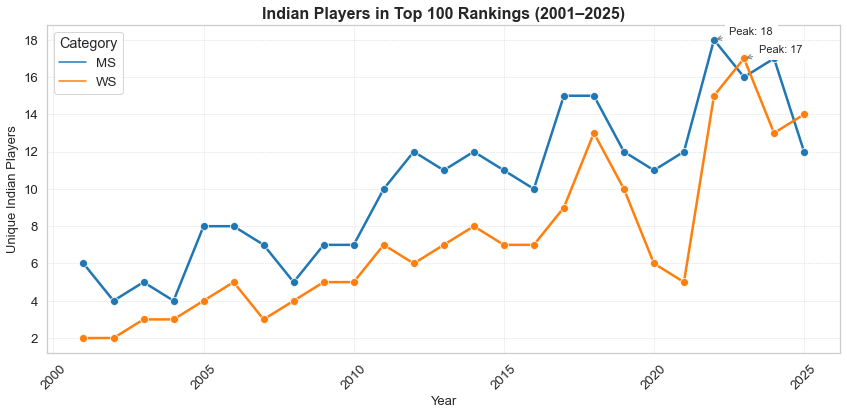

In [10]:
indian_players['Year'] = pd.to_datetime(indian_players['Date']).dt.year

# Number of Indian players in top 100 each year
yearly_counts = indian_players.groupby(['Year', 'Category'])['Player'].nunique().reset_index()
print(yearly_counts)

# Plotting
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 6))

# Custom palette
custom_palette = {'MS': '#1f77b4', 'WS': '#ff7f0e'}

# Lineplot with style
ax = sns.lineplot(
    data=yearly_counts,
    x='Year',
    y='Player',
    hue='Category',
    marker='o',
    palette=custom_palette,
    linewidth=2.5,
    markersize=8
)

# Annotate peak year per category
for cat in yearly_counts['Category'].unique():
    subset = yearly_counts[yearly_counts['Category'] == cat]
    peak = subset.loc[subset['Player'].idxmax()]
    ax.annotate(
        f"Peak: {peak['Player']}",
        xy=(peak['Year'], peak['Player']),
        xytext=(peak['Year'] + 0.5, peak['Player'] + 0.3),
        arrowprops=dict(arrowstyle='->', color='gray'),
        fontsize=11,
        backgroundcolor='white'
    )

# Final formatting
plt.title('Indian Players in Top 100 Rankings (2001–2025)', fontsize=16, weight='bold')
plt.xlabel('Year', fontsize=13)
plt.ylabel('Unique Indian Players', fontsize=13)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.legend(title="Category")
plt.show()

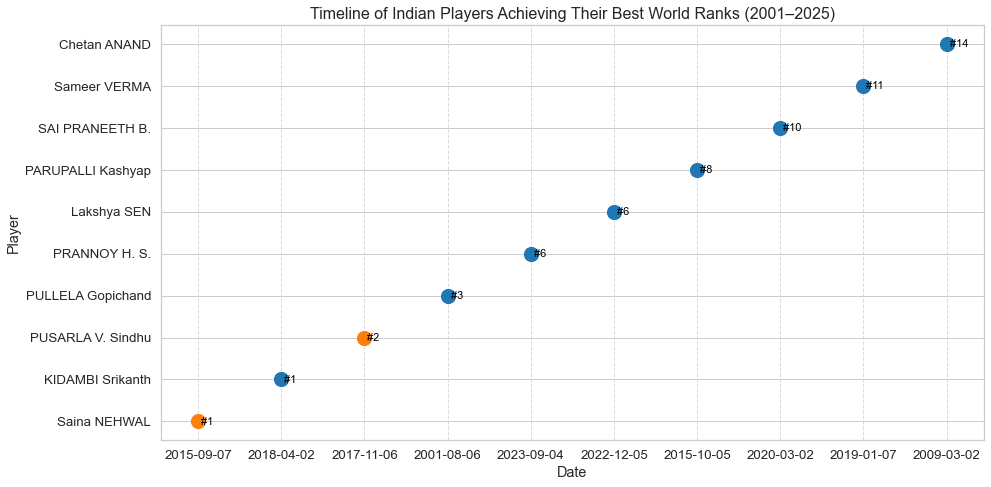

In [11]:
palette = {'MS': '#1f77b4', 'WS': '#ff7f0e'}
plt.figure(figsize=(14, 7))
for i, row in best_ranks.iterrows():
    plt.scatter(row['Date'], row['Player'], s=200, color=palette[row['Category']])
    plt.text(row['Date'], row['Player'], f" #{row['Rank']}", va='center', ha='left', fontsize=11, color='black')
plt.title("Timeline of Indian Players Achieving Their Best World Ranks (2001–2025)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Player")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

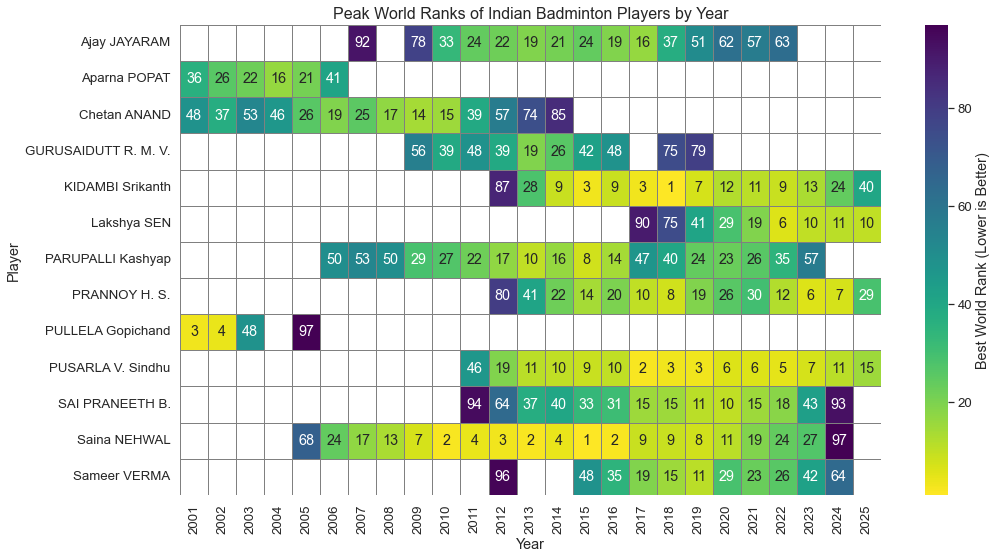

In [ ]:
# Ensure 'Year' column exists and is integer
df_full['Year'] = pd.to_datetime(df_full['Date']).dt.year

# Filter for Indian players only
indian_df = df_full[df_full['Country'] == 'India'].copy()

# For each player and year, get their best (lowest) rank
peak_ranks = indian_df.pivot_table(
    index='Player',
    columns='Year',
    values='Rank',
    aggfunc='min'
)


peak_ranks = peak_ranks[peak_ranks.min(axis=1) <= 20]

plt.figure(figsize=(15, 8))
sns.heatmap(
    peak_ranks,
    cmap='viridis_r',
    annot=True,
    fmt='.0f',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Best World Rank (Lower is Better)'}
)
plt.title('Peak World Ranks of Indian Badminton Players by Year', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

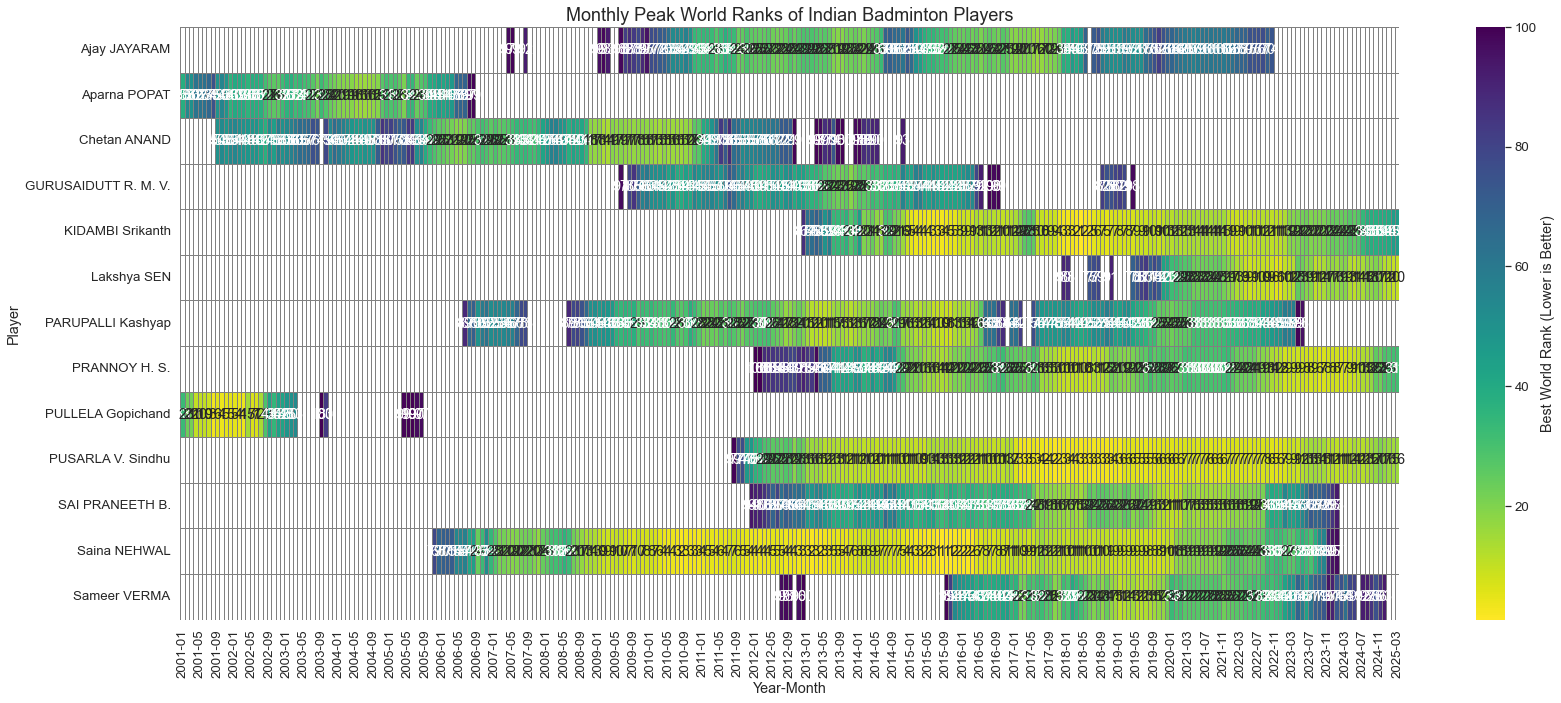

In [21]:
# Ensure 'Date' is datetime
df_full['Date'] = pd.to_datetime(df_full['Date'])

# Filter for Indian players
indian_df = df_full[df_full['Country'] == 'India'].copy()

# Extract year and month as a string (e.g., '2022-03')
indian_df['YearMonth'] = indian_df['Date'].dt.to_period('M').astype(str)

# Create a pivot table: rows = Player, columns = Year-Month, values = best (lowest) Rank in that month
monthly_peak_ranks = indian_df.pivot_table(
    index='Player',
    columns='YearMonth',
    values='Rank',
    aggfunc='min'
)

# Optional: Keep only players who have ever been in the top 20
monthly_peak_ranks = monthly_peak_ranks[monthly_peak_ranks.min(axis=1) <= 20]

plt.figure(figsize=(24, 10))
sns.heatmap(
    monthly_peak_ranks,
    cmap='viridis_r',
    annot=True,  # Set to True for numbers, but can get crowded
    linewidths=0.5,
    fmt='.0f',
    linecolor='gray',
    cbar_kws={'label': 'Best World Rank (Lower is Better)'}
)
plt.title('Monthly Peak World Ranks of Indian Badminton Players', fontsize=18)
plt.xlabel('Year-Month')
plt.ylabel('Player')
plt.tight_layout()
plt.show()